# Purpose
The purpose is to calculate the log-normal mixed logit probabilities.

# Load needed libraries

In [1]:
import sys
from copy import deepcopy
from collections import OrderedDict
from collections import defaultdict

import scipy.stats
import pandas as pd
import numpy as np

from tqdm import tqdm

import pylogit as pl
import pylogit.mixed_logit_calcs as mlc
from pylogit.choice_tools import get_original_order_unique_ids

sys.path.insert(0, '../src/')
from visualization import predictive_viz as viz

%matplotlib inline

/Users/timothyb0912/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


# Load needed data

In [2]:
car_df = pd.read_csv("../data/processed/model_ready_car_data.csv")
forecast_df = pd.read_csv("../data/processed/forecast_car_data.csv")

# Create specification dictionaries

In [3]:
mnl_spec, mnl_names = OrderedDict(), OrderedDict()

orig_cols_and_display_names =\
    [("neg_price_over_log_income", 'Neg Price over log(income)'),
     ('range_over_100', 'Range (units: 100mi)'),
     ("neg_acceleration_over_10", 'Neg Acceleration (units: 0.1sec)'),
     ('top_speed_over_100', 'Neg Top speed (units: 0.01mph)'),
     ("neg_pollution", 'Neg Pollution'),
     ('vehicle_size_over_10', 'Size'),
     ('big_enough', 'Big enough'),
     ('luggage_space', 'Luggage space'),
     ("neg_tens_of_cents_per_mile", 'Neg Operation cost'),
     ('station_availability', 'Station availability'),
     ('sports_utility_vehicle', 'Sports utility vehicle'),
     ('sports_car', 'Sports car'),
     ('station_wagon', 'Station wagon'),
     ('truck', 'Truck'),
     ('van', 'Van'),
     ('electric', 'EV'),
     ('electric_commute_lte_5mi', 'Commute < 5 & EV'),
     ('electric_and_college', 'College & EV'),
     ('compressed_natural_gas', 'CNG'),
     ('methanol', 'Methanol'),
     ('methanol_and_college', 'College & Methanol'),
     ('non_ev', 'Non Electric-Vehicle'),
     ('non_cng', 'Non Compressed Natural Gas')]
    
for col, display_name in orig_cols_and_display_names:
    mnl_spec[col] = 'all_same'
    mnl_names[col] = display_name

In [4]:
# Approach 1: Use a for loop.
# Estimate an mnl with the same basic specification as the MIXL.
mnl_model =\
    pl.create_choice_model(data=car_df,
                           alt_id_col='alt_id',
                           obs_id_col='obs_id',
                           choice_col='choice',
                           specification=mnl_spec,
                           model_type='MNL',
                           names=mnl_names)
    
mnl_model.fit_mle(np.zeros(len(mnl_names)),
                  constrained_pos=[-2, -1])

# Look at the estimation results
mnl_model.get_statsmodels_summary()

Log-likelihood at zero: -8,338.8486
Initial Log-likelihood: -8,338.8486


/Users/timothyb0912/anaconda/lib/python2.7/site-packages/scipy/optimize/_minimize.py:507: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.33 seconds.
Final log-likelihood: -7,391.8300


/Users/timothyb0912/anaconda/lib/python2.7/site-packages/pylogit/base_multinomial_cm_v2.py:1228: RuntimeWarning: invalid value encountered in sqrt
  self._store_inferential_results(np.sqrt(np.diag(self.cov)),
/Users/timothyb0912/anaconda/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/timothyb0912/anaconda/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/timothyb0912/anaconda/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/timothyb0912/anaconda/lib/python2.7/site-packages/pylogit/base_multinomial_cm_v2.py:1259: RuntimeWarning: invalid value encountered in sqrt
  self._store_inferential_results(np.sqrt(np.diag(self.robust_cov)),


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Multinomial Logit Model Regression Results                    
===================================================================================
Dep. Variable:                      choice   No. Observations:                4,654
Model:             Multinomial Logit Model   Df Residuals:                    4,631
Method:                                MLE   Df Model:                           23
Date:                     Sun, 10 Jun 2018   Pseudo R-squ.:                   0.114
Time:                             17:03:06   Pseudo R-bar-squ.:               0.111
AIC:                            14,829.660   Log-Likelihood:             -7,391.830
BIC:                            14,977.906   LL-Null:                    -8,338.849
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Neg Price over log(income)           0.1854      0.027      6.796      0.000       0.132       0.239
Range (units: 100mi)                 0.3501      0.027     13.052      0.000       0.298       0.403
Neg Acceleration (units: 0.1sec)     0.7160      0.111      6.472      0.000       0.499       0.933
Neg Top speed (units: 0.01mph)       0.2612      0.081      3.228      0.001       0.103       0.420
Neg Pollution                        0.4441      0.102      4.367      0.000       0.245       0.643
Size                                 0.9345      0.316      2.953      0.003       0.314       1.555
Big enough                           0.1432      0.077      1.853      0.064      -0.008       0.295
Luggage space                        0.5009      0.191      2.623      0.009       0.127       0.875
Neg Operation cost                   0.7679      0.076     10.131      0.000       0.619       0.916
Station availability                 0.4133      0.096      4.294      0.000       0.225       0.602
Sports utility vehicle               0.8201      0.141      5.830      0.000       0.544       1.096
Sports car                           0.6370      0.148      4.298      0.000       0.347       0.928
Station wagon                       -1.4367      0.062    -23.139      0.000      -1.558      -1.315
Truck                               -1.0168      0.049    -20.753      0.000      -1.113      -0.921
Van                                 -0.7989      0.047    -16.864      0.000      -0.892      -0.706
EV                                  -0.1786        nan        nan        nan         nan         nan
Commute < 5 & EV                     0.1983      0.084      2.374      0.018       0.035       0.362
College & EV                         0.4426      0.109      4.058      0.000       0.229       0.656
CNG                                  0.3450      0.372      0.928      0.353      -0.384       1.074
Methanol                             0.3134      0.103      3.051      0.002       0.112       0.515
College & Methanol                   0.2284      0.089      2.576      0.010       0.055       0.402
Non Electric-Vehicle                      0        nan        nan        nan         nan         nan
Non Compressed Natural Gas                0        nan        nan        nan         nan         nan
====================================================================================================
"""

In [5]:
# Convert the 'estimate' column of Table 2 in
# Brownstone & Train (1998) into their equivalent
# 'mu' values for the log-normal distributions
get_ln_Loc = lambda x: np.log(x) - (0.8326**2) * 0.5

get_ln_Loc(0.588), get_ln_Loc(0.286)

(-0.8776397110835102, -1.5983748481622846)

From the cell above, we can see that the 2nd column in Table 2 of Brownstone & Train (1998) has been entered incorrectly. The value for Price / ln(income) should be -1.598 instead of -5.999.

In [6]:
%pdb on
# Determine the variables being mixed
mixing_vars = ['neg_price_over_log_income',
               'neg_acceleration_over_10',
               'neg_pollution',
               'neg_tens_of_cents_per_mile',
               'range_over_100',
               'top_speed_over_100',
               'big_enough',
               'station_availability',
               'vehicle_size_over_10',
               'luggage_space',
               'non_ev',
               'non_cng']

# Determine the log-normal mixing variables
lognormal_vars = mixing_vars[:-4]
normal_vars = mixing_vars[4:]

# Store the model parameters from Brownstone and Train (1998)
param_values = np.array([-1.5983748481622846, #-5.999,
                         -0.877,
                         -0.302,
                         -1.364,
                         -0.711,
                          1.541,
                         -1.748,
                          1.563,
                         -0.071,
                         -0.741,
                          0.897,
                          0.698,
                         -1.508,
                         -1.094,
                         -0.819,
                         -0.905,
                          0.359,
                          0.770,
                          0.621,
                          0.476,
                          0.335,
                          0,
                          0])

# Initialize the array of standard deviation values
std_values = np.zeros(param_values.size)

# Store Brownstone & Train's standard dev values for
# the values with normal mixing distributions
std_dict = {'non_ev': 2.289,
            'non_cng': 0.971,
            'vehicle_size_over_10': 6.808,
            'luggage_space': 5.380}

# Extract the variable names for the systematic utilities
variable_names = [x[0] for x in orig_cols_and_display_names]

# Populate the array of standard deviation values
for pos, variable in enumerate(variable_names):
    # Assign the correct standard deviation value for this
    if variable in mixing_vars:
        if variable in std_dict:
            std_values[pos] = std_dict[variable]
        elif variable in lognormal_vars:
            # Based on Brownstone & Train (1998)
            # pg. 125, last paragraph
            std_values[pos] = 0.8326
            
# Determine the number of mixing variables
num_mixing_vars = len(mixing_vars)

# Determine the number of draws being used for the mixed logit
num_draws = 250
# num_draws = 1000

# Initialize a num_rows by num_draws matrix for probabilities
orig_mixl_probs = np.empty((car_df.shape[0], num_draws))
forecast_mixl_probs = np.empty((car_df.shape[0], num_draws))

# Determine the number of observations with randomly distributed
# sensitivities
num_mixers = car_df.obs_id.unique().size

# Get the random draws needed for the draws of each coeffcient
# Each element in the list will be a 2D ndarray of shape
# num_mixers by num_draws
normal_rvs_list =\
    mlc.get_normal_draws(num_mixers,
                         num_draws,
                         num_mixing_vars,
                         seed=601)
    
# Get the unique obs_id values, in their original order
unique_obs_ids =\
    get_original_order_unique_ids(car_df.obs_id.values)
    
# Initialize the coefficient matrix for all observations
coef_matrix = param_values[:, None] * np.ones(num_draws)[None, :]

# Create an object to iterate over
iterator = tqdm(unique_obs_ids, desc='Observations')

# For each observation in the original obs_id order:
for obs_row, obs_id in enumerate(iterator):
    # Determine the long format rows for the current obs
    row_idx = np.where(car_df.obs_id == obs_id)[0]

    # Form a num_index_coefs by num_draws matrix of coefficients
    # for this individual
    for var_row, variable in enumerate(variable_names):
        if variable not in mixing_vars:
            continue
        else:
            # Get the position in the array of mixing vars
            mixing_pos = mixing_vars.index(variable)
            
            # Get the draws for this observation and variable
            draws = normal_rvs_list[mixing_pos][obs_row, :]
            
            # Form the array of coefficients
            coefs = (param_values[var_row] + 
                     std_values[var_row] * draws)
            if variable in lognormal_vars:
                coefs = np.exp(np.clip(coefs,
                                       mlc.min_exponent_val,
                                       mlc.max_exponent_val))
                
            # Store the array of coefficients
            coef_matrix[var_row, :] = coefs

    # Subset the original dataframe by selecting the rows
    # just for the current observation.
    obs_data_orig = car_df.iloc[row_idx, :]
    obs_data_forecast = forecast_df.iloc[row_idx, :]

    # Create the param list for predictions
    param_list = [coef_matrix, None, None, None]

    # Using the original MNL model, call predict using the
    # subsetted dataframe and the num_index_coefs by
    # num_draws matrix of coefficients for that individual.
    obs_sim_probs_orig =\
        mnl_model.predict(obs_data_orig, param_list)
    obs_sim_probs_forecast =\
        mnl_model.predict(obs_data_forecast, param_list)

    # Store the predictions in forecast_mixl_probs
    orig_mixl_probs[row_idx, :] = obs_sim_probs_orig
    forecast_mixl_probs[row_idx, :] = obs_sim_probs_forecast

# Take the mean across axis 1 of the matrix of predictions.
# These are the predicted probabilities
final_mixl_probs_orig = orig_mixl_probs.mean(axis=1)
final_mixl_probs_forecast = forecast_mixl_probs.mean(axis=1)

# Store the Computed probabilities
np.savetxt('../data/processed/lognormal_mixl_probs_mle.csv',
           final_mixl_probs_orig,
           delimiter=',')

np.savetxt('../data/processed/lognormal_mixl_probs_mle_forecast.csv',
           final_mixl_probs_forecast,
           delimiter=',')

Automatic pdb calling has been turned ON


Observations: 100%|██████████| 4654/4654 [00:31<00:00, 148.37it/s]


# Sanity check

In [7]:
# Make sure none of the predicted probabilities are NaN
np.isnan(final_mixl_probs_orig).any()

False

In [8]:
# Look at the distribution of predicted probabilities
pd.Series(final_mixl_probs_orig).describe()

count    27924.000000
mean         0.166667
std          0.111085
min          0.008662
25%          0.080818
50%          0.135765
75%          0.228371
max          0.646645
dtype: float64

In [9]:
# Look at the log-likelihood based on Approach 1.
# Check that it is near the log-likelihood reported in
# Brownstone & train 
log_like = car_df.choice.dot(np.log(final_mixl_probs_orig))
print('MIXL Log-Likelihood: {:3f}'.format(log_like))

MIXL Log-Likelihood: -7370.086359


In [10]:
# Ensure the forecast probabilities for large gas cars are
# higher than the original probabilities for large gas cars
large_gas_car_idx = ((car_df['body_type'] == 'regcar') &
                     (car_df['vehicle_size'] == 3) &
                     (car_df['fuel_type'] == 'gasoline')).values
num_stupid_forecasts =\
    ((final_mixl_probs_forecast >
      final_mixl_probs_orig)[large_gas_car_idx]).sum()
print("{:,} stupid forecasts".format(num_stupid_forecasts))

0 stupid forecasts


In [11]:
# Look at the mixed logits predicted change in the market share
# of large gas cars after the price increase.
(((final_mixl_probs_forecast[large_gas_car_idx]).sum() -
 (final_mixl_probs_orig[large_gas_car_idx]).sum()) /
 (final_mixl_probs_orig[large_gas_car_idx]).sum())

-0.12205116117304653

count    5000.000000
mean       -1.005785
std         1.940447
min       -62.316673
25%        -1.103588
50%        -0.509510
75%        -0.227775
max        -0.008702
dtype: float64


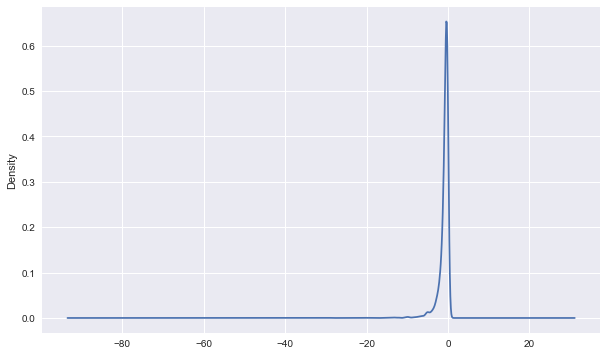

In [12]:
# Note the assumed standard deviation
assumed_std = 0.8326

# Look at the distribution of the ratio of the 
# relative price coefficient  to the range coefficient.
# This will tell how 'well captured' this ratio of coefficients
# is, and/or how much the log-normal mixed logit results
# are to be trusted.

price_dist = scipy.stats.lognorm(s=assumed_std,
                                 scale=np.exp(-1.5983748481622846))

range_dist = scipy.stats.lognorm(s=assumed_std,
                                 scale=np.exp(-0.877))

# Sample the ratio of coefficients
num_samples = 5000
price_samples = -1 * price_dist.rvs(size=num_samples)
range_samples = range_dist.rvs(size=num_samples)
ratio_samples = pd.Series(price_samples / range_samples)

# Display a text representation of the distribution
print(ratio_samples.describe())

# Display a KDE of the distribution
ratio_samples.plot(kind='kde', figsize=(10, 6))